# Strategy 1: Borrowing interest rate based strategy

_Feedback from previous notebook_

Looks good, let's try Z-score model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as mtick
from common_models import DataSource, Trade, StrategySummary
from datetime import datetime, timedelta, UTC
from typing import Dict, List
import json
import requests
from utils import load_data, BINANCE_DOWNLOAD_FILE_NAME
from pathlib import Path
%matplotlib inline

In [2]:
# Change it to `DataSource.LIVE` to pull updated data from Binance
data_source = DataSource.LOCAL

In [3]:
df_all = None
if data_source == DataSource.LOCAL:
    if Path(BINANCE_DOWNLOAD_FILE_NAME).exists():
        df_all = pd.read_csv(BINANCE_DOWNLOAD_FILE_NAME)
    else:
        print("Local data file not found!")
if not df_all:
    from binance_secrets import api_key, api_secret
    assets = [
        "BTC",
        "ETH",
        "SOL",
        "BNB",
        "XRP",
        "ADA",
        "AVAX",
        "DOGE",
        "DOT",
        "TRX",
        "LINK",
        "MATIC",
        "SHIB",
        "LTC",
    ]
    df_all = load_data(
        api_key=api_key,
        api_secret=api_secret,
        interest_rate_assets=["USDT"] + assets,
        price_assets=[
            f"{a}USDT" for a in assets
        ],
        start_date=datetime(2023, 3, 1),
        end_date=datetime(2023, 12, 20))

Local data file not found!


Getting Prices: 100%|█████████████████████████████████████████████████████| 14/14 [00:48<00:00,  3.43s/it]

Saving downloaded data...


In [4]:
df_all

,USDT,BTC,ETH,SOL,BNB,XRP,ADA,AVAX,DOGE,DOT,...,MATICUSDT_low,MATICUSDT_close,SHIBUSDT_open,SHIBUSDT_high,SHIBUSDT_low,SHIBUSDT_close,LTCUSDT_open,LTCUSDT_high,LTCUSDT_low,LTCUSDT_close
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00+00:00,0.000256,0.000110,0.000110,0.000877,0.003479,0.000699,0.000301,0.000444,0.000232,0.000493,...,1.1903,1.1956,0.000012,0.000012,0.000012,0.000012,93.79,94.56,93.56,93.99
2023-03-01 01:00:00+00:00,0.000256,0.000110,0.000110,0.000877,0.003479,0.000699,0.000301,0.000444,0.000232,0.000493,...,1.1934,1.2088,0.000012,0.000012,0.000012,0.000012,93.99,94.76,93.87,94.65
2023-03-01 02:00:00+00:00,0.000256,0.000110,0.000110,0.000877,0.003479,0.000699,0.000301,0.000444,0.000232,0.000493,...,1.2084,1.2234,0.000012,0.000012,0.000012,0.000012,94.65,95.31,94.61,95.28
2023-03-01 03:00:00+00:00,0.000256,0.000110,0.000110,0.000877,0.003479,0.000699,0.000301,0.000444,0.000232,0.000493,...,1.2207,1.2302,0.000012,0.000012,0.000012,0.000012,95.27,96.55,95.27,96.08
2023-03-01 04:00:00+00:00,0.000256,0.000110,0.000110,0.000877,0.003479,0.000699,0.000301,0.000444,0.000232,0.000493,...,1.2269,1.2466,0.000012,0.000012,0.000012,0.000012,96.07,97.50,95.97,97.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19 20:00:00+00:00,0.000812,0.000033,0.000067,0.000170,0.004110,0.000270,0.000193,0.000123,0.000180,0.000424,...,0.7590,0.7593,0.000010,0.000010,0.000010,0.000010,70.57,70.80,70.16,70.34
2023-12-19 21:00:00+00:00,0.000812,0.000033,0.000067,0.000170,0.004110,0.000270,0.000189,0.000123,0.000180,0.000424,...,0.7566,0.7707,0.000010,0.000010,0.000010,0.000010,70.35,70.79,70.32,70.77
2023-12-19 22:00:00+00:00,0.000803,0.000033,0.000067,0.000166,0.004110,0.000275,0.000189,0.000123,0.000180,0.000424,...,0.7615,0.7640,0.000010,0.000010,0.000010,0.000010,70.78,70.78,70.34,70.51


In [4]:
df_all.columns

Index(['USDT', 'BTC', 'ETH', 'SOL', 'BNB', 'XRP', 'ADA', 'AVAX', 'DOGE', 'DOT',
       'TRX', 'LINK', 'MATIC', 'SHIB', 'LTC', 'BTCUSDT_open', 'BTCUSDT_high',
       'BTCUSDT_low', 'BTCUSDT_close', 'ETHUSDT_open', 'ETHUSDT_high',
       'ETHUSDT_low', 'ETHUSDT_close', 'SOLUSDT_open', 'SOLUSDT_high',
       'SOLUSDT_low', 'SOLUSDT_close', 'BNBUSDT_open', 'BNBUSDT_high',
       'BNBUSDT_low', 'BNBUSDT_close', 'XRPUSDT_open', 'XRPUSDT_high',
       'XRPUSDT_low', 'XRPUSDT_close', 'ADAUSDT_open', 'ADAUSDT_high',
       'ADAUSDT_low', 'ADAUSDT_close', 'AVAXUSDT_open', 'AVAXUSDT_high',
       'AVAXUSDT_low', 'AVAXUSDT_close', 'DOGEUSDT_open', 'DOGEUSDT_high',
       'DOGEUSDT_low', 'DOGEUSDT_close', 'DOTUSDT_open', 'DOTUSDT_high',
       'DOTUSDT_low', 'DOTUSDT_close', 'TRXUSDT_open', 'TRXUSDT_high',
       'TRXUSDT_low', 'TRXUSDT_close', 'LINKUSDT_open', 'LINKUSDT_high',
       'LINKUSDT_low', 'LINKUSDT_close', 'MATICUSDT_open', 'MATICUSDT_high',
       'MATICUSDT_low', 'MATICUSDT_close', 'S

In [5]:
def generate_indicator(interest_rate_currency: str, rolling_window: int) -> pd.Series:
    """Generate Z Score indicator
    """
    rolling = df_all[interest_rate_currency].rolling(rolling_window)
    return ((df_all[interest_rate_currency] - rolling.mean().shift(1)) / rolling.std(ddof=0).shift(1)).rename("indicator")

In [6]:
def generate_signal(indicator: pd.Series, threshold: float) -> pd.Series:
    """Convert indicator into signals
    """
    return (indicator > threshold).rename("signal")

In [7]:
def run_strategy(starting_capital: int, interest_rate_currency: str, symbol: str, rolling_window: int, threshold: float, risk_free_rate: float, verbose: bool = False):
    indicator = generate_indicator(interest_rate_currency=interest_rate_currency, rolling_window=rolling_window)
    signal = generate_signal(indicator, threshold=threshold)
    close_col = f"{symbol}_close"

    _df = df_all[[c for c in df_all.columns if (c.startswith(symbol) and len(c) > len(symbol))]]
    _df = _df.join(signal).dropna(subset=["signal", close_col])

    if verbose:
        print(f"Date Range: {_df.index.min()} till {_df.index.max()}")
        print(f"No. of Trading Days: {len(_df)}")

    cash = starting_capital
    position = 0

    opening_cash = []
    opening_position = []
    closing_cash = []
    closing_position = []

    trades = []

    for id, row in _df[["signal", close_col]].iterrows():
        opening_cash.append(cash)
        opening_position.append(position)
        if row["signal"] and position == 0:
            amount = cash
            unit = amount / row[close_col]
            position += unit
            cash -= amount
            trade = Trade(
                date=id,
                btc_close_price=row[close_col],
                trade_type=True,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        elif (not row["signal"]) and position > 0:
            unit = position
            amount = unit * row[close_col]
            position -= unit
            cash += amount
            trade = Trade(
                date=id,
                btc_close_price=row[close_col],
                trade_type=False,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        closing_cash.append(cash)
        closing_position.append(position)

    
    _df["opening_cash"] = opening_cash
    _df["opening_position"] = opening_position
    _df["closing_cash"] = closing_cash
    _df["closing_position"] = closing_position
    
    _df["closing_value"] = _df["closing_cash"] + _df["closing_position"] * _df[close_col]
    _df["return"] = _df["closing_value"].pct_change()
    _df["excess_return"] = _df["return"] - risk_free_rate
    _df["drawdown_pct"] = 1 - _df["closing_value"] / _df["closing_value"].expanding().max()
    _df["drawdown_period"] = _df["drawdown_pct"].groupby((_df["drawdown_pct"] == 0).cumsum()).cumcount()

    perf = StrategySummary(
        start_date=_df.index[0],
        end_date=_df.index[-1],
        starting_capital=starting_capital,
        trades=trades,
        total_pnl=_df["closing_value"].iloc[-1] - starting_capital,
        total_pnl_pct=_df["closing_value"].iloc[-1] / starting_capital - 1,
        sharpe_ratio=(_df['excess_return'].mean() / _df['excess_return'].std()) if len(trades) > 0 else None,
        days_in_market=(_df["closing_position"] > 0).sum(),
        days_in_market_pct=(_df["closing_position"] > 0).mean(),
        portfolio_value_timeline=_df["closing_value"],
        max_drawdown_pct=_df["drawdown_pct"].max(),
        max_drawdown_period=_df["drawdown_period"].max(),
        drawdown_period_timeline=_df["drawdown_period"],
        watermark_timeline=_df["drawdown_pct"]
    )
    return perf

In [8]:
time_period = 365 * 24 # 1Y to hours
risk_free_rate = .0494 / time_period # 1Y T Bill

In [9]:
look_back_period_limit = len(df_all) // 10
look_back_period_limit

705

In [10]:
_ = 10
windows = []
while _ < look_back_period_limit:
    windows.append(_)
    _ *= 2
windows

[10, 20, 40, 80, 160, 320, 640]

100%|████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.81s/it]


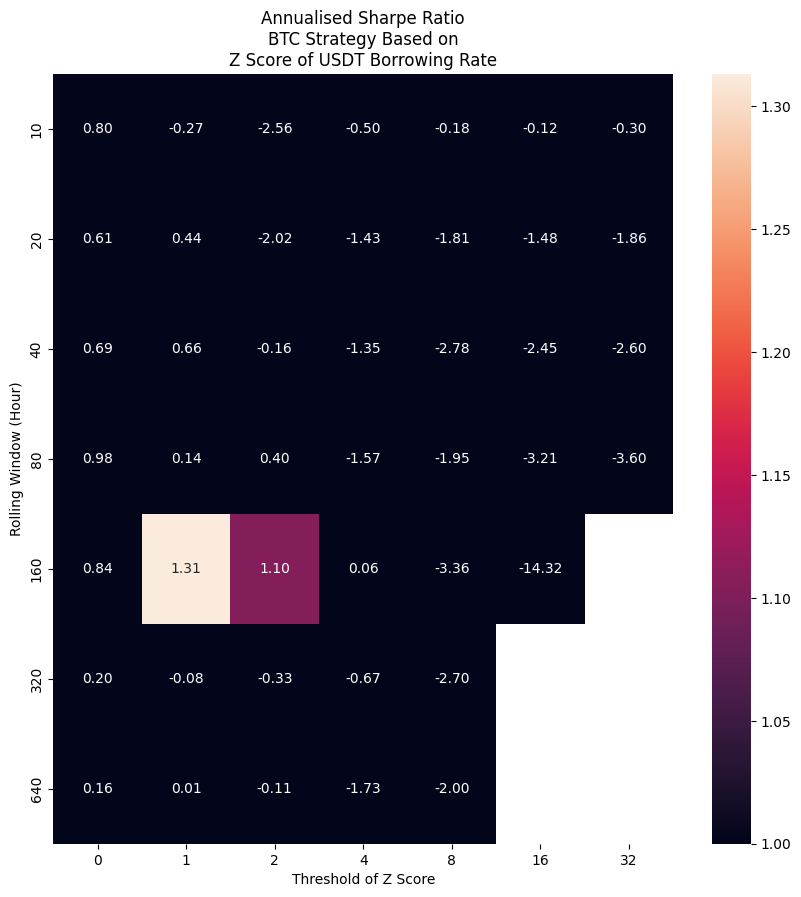

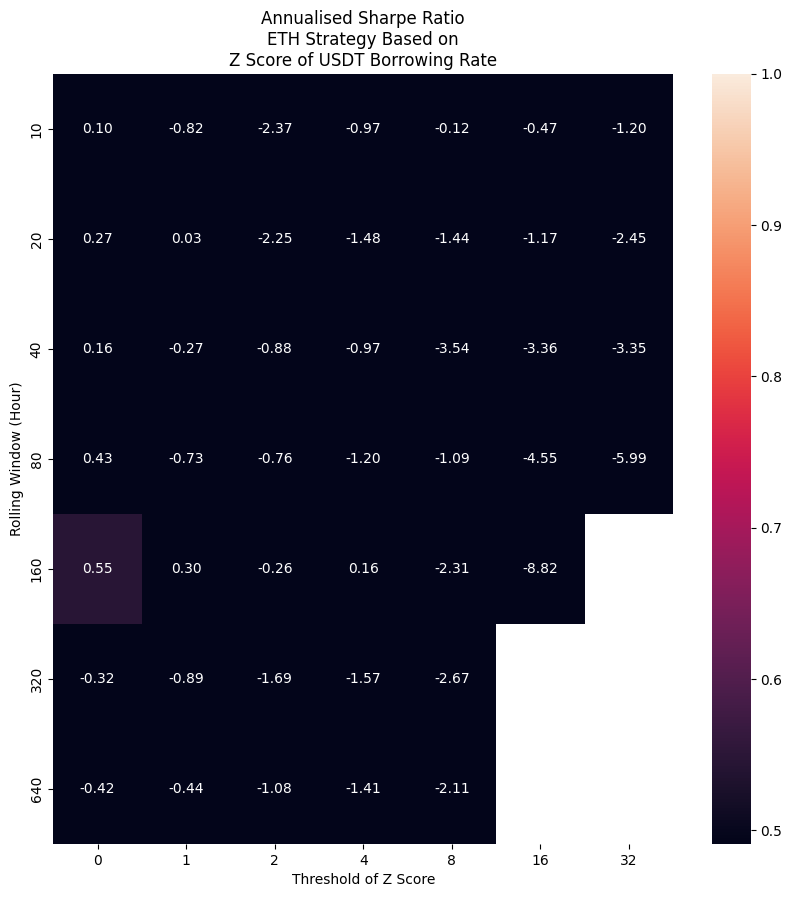

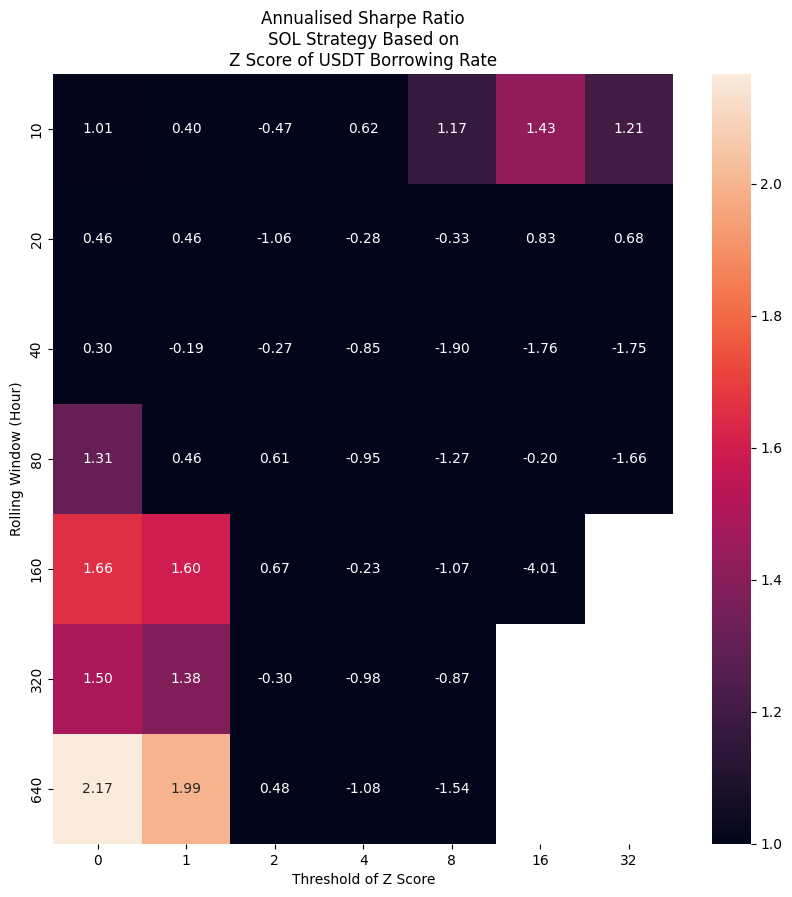

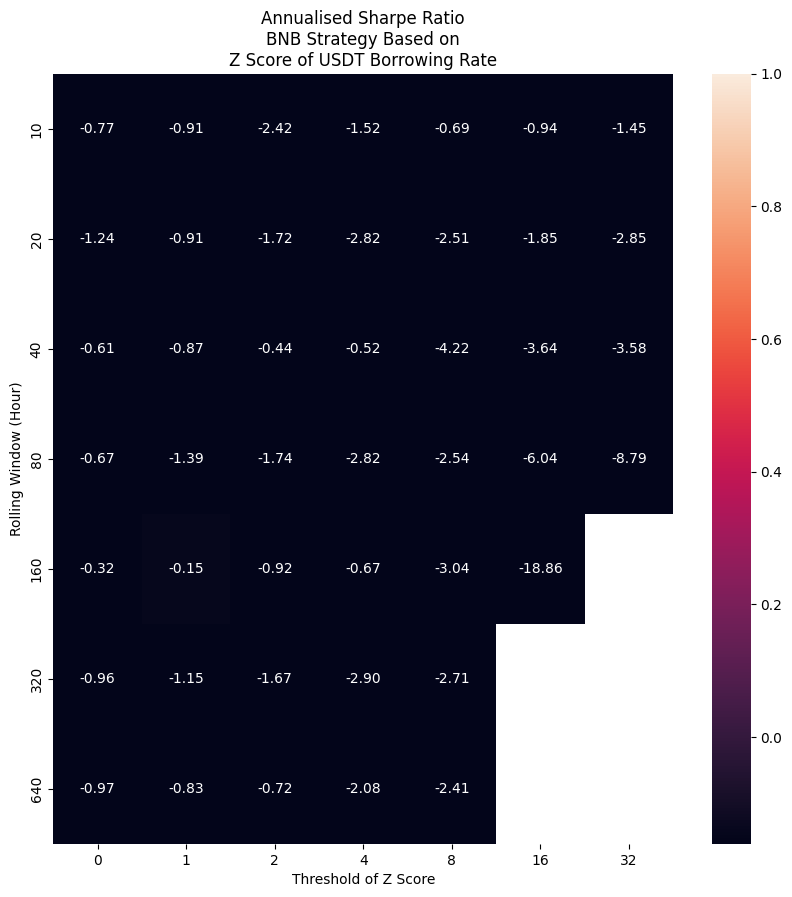

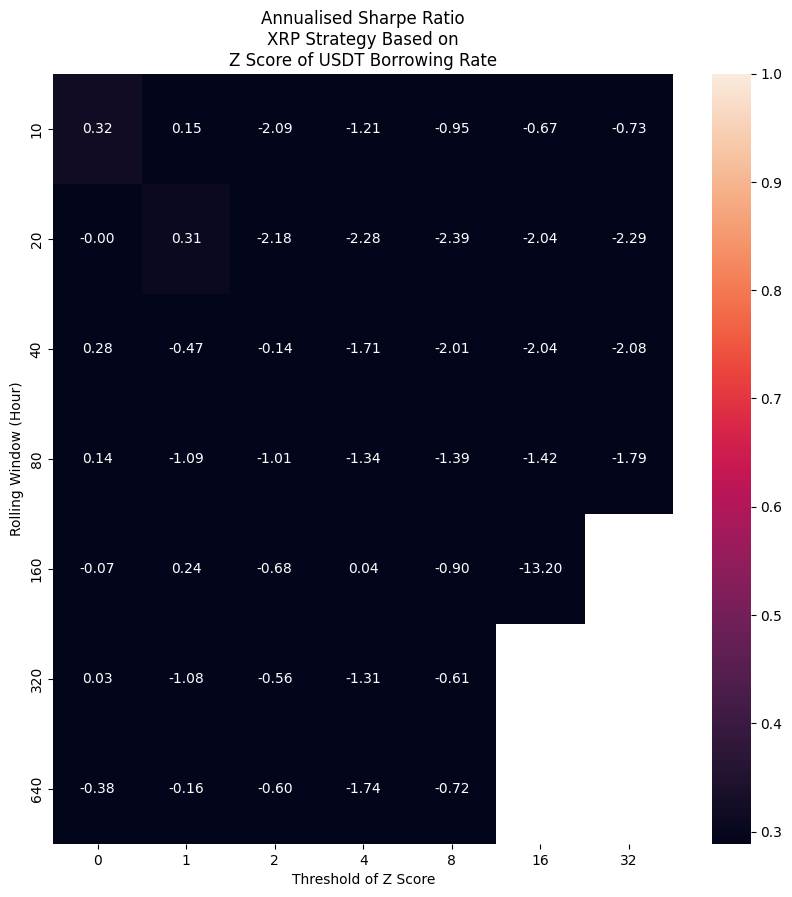

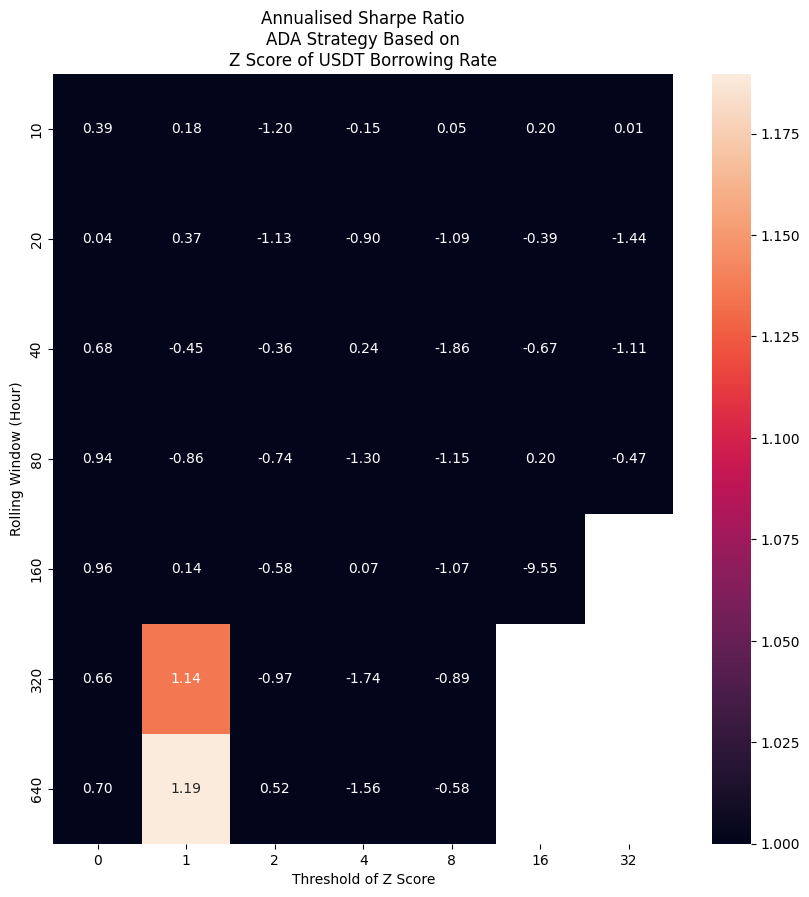

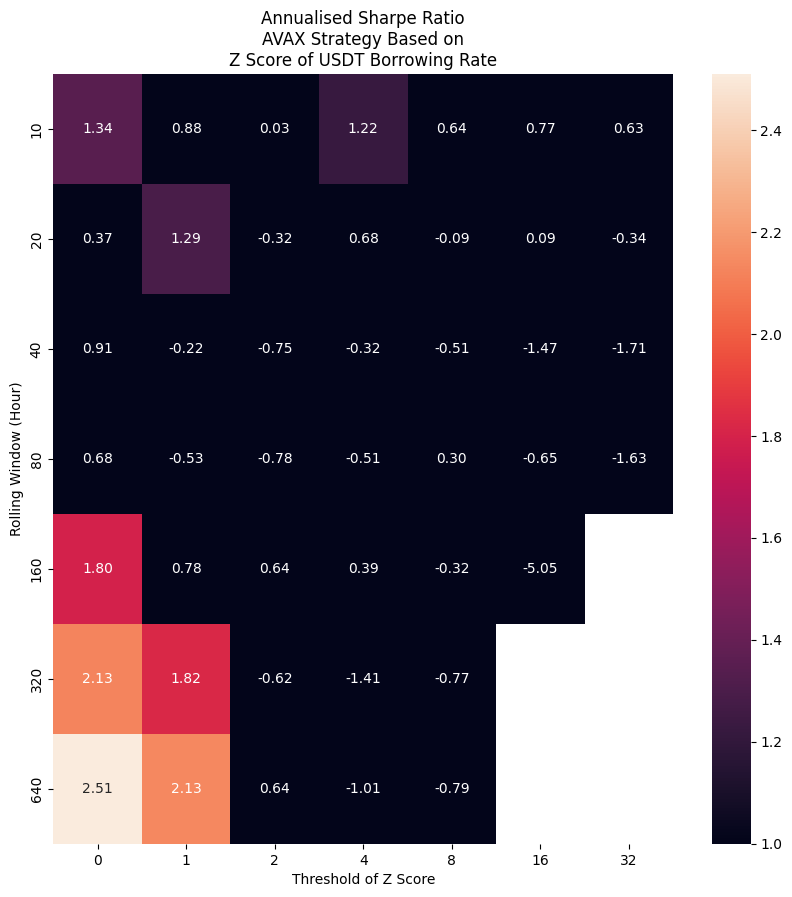

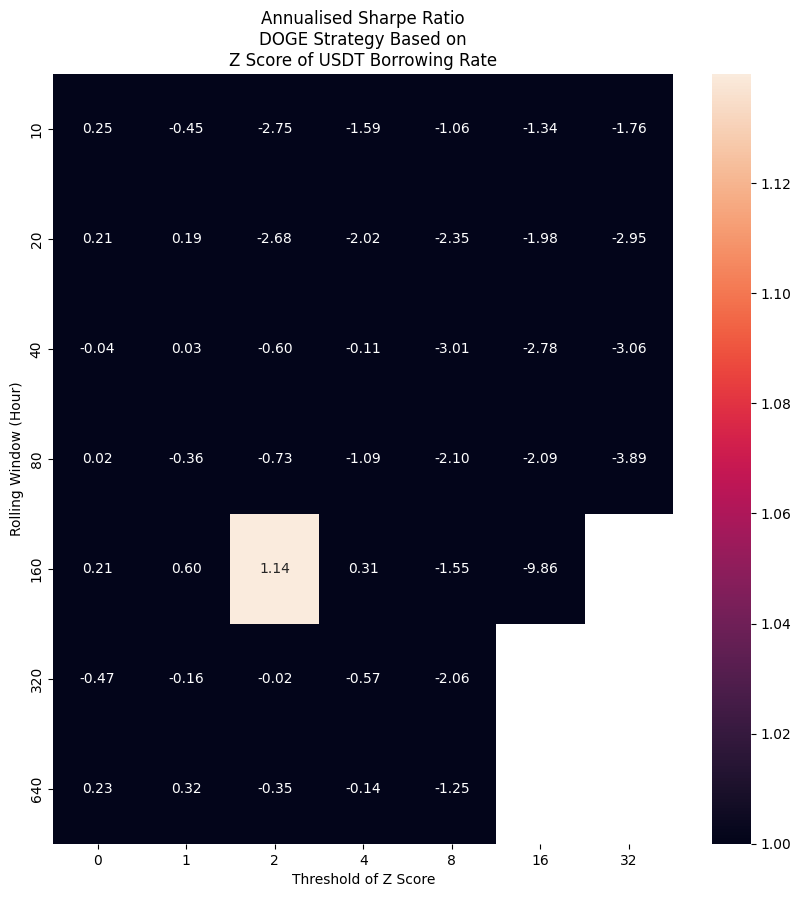

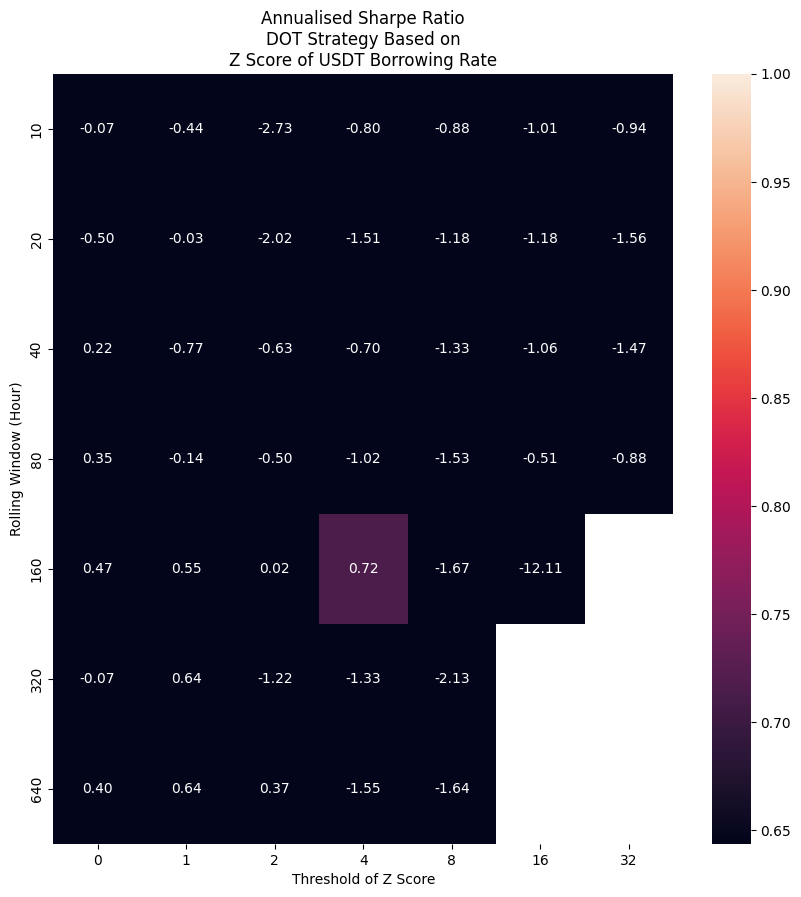

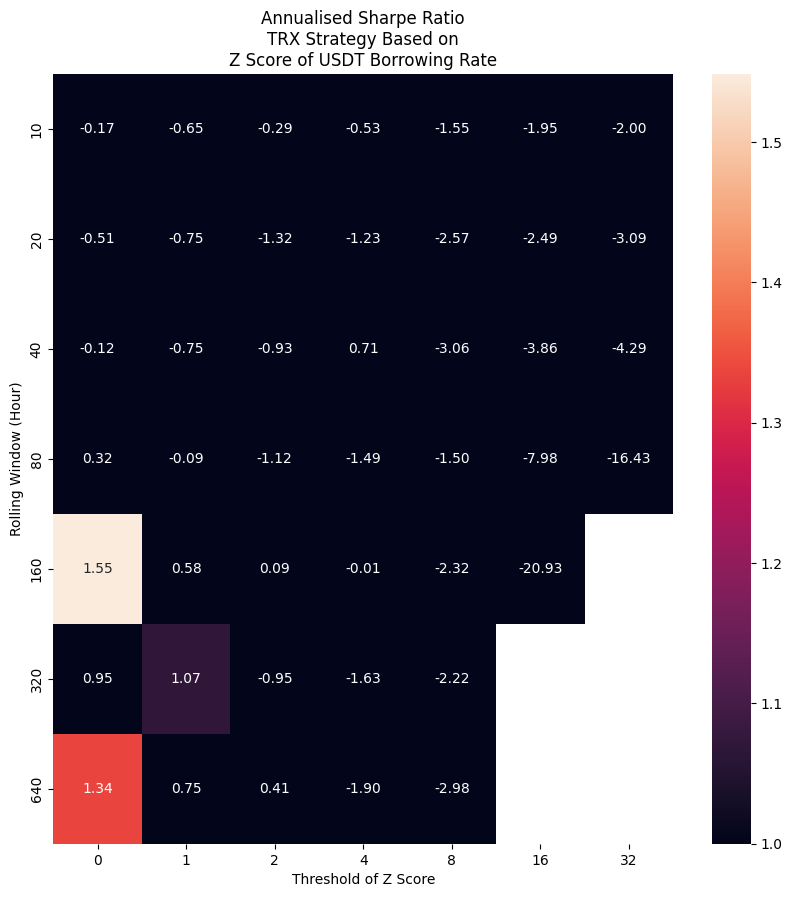

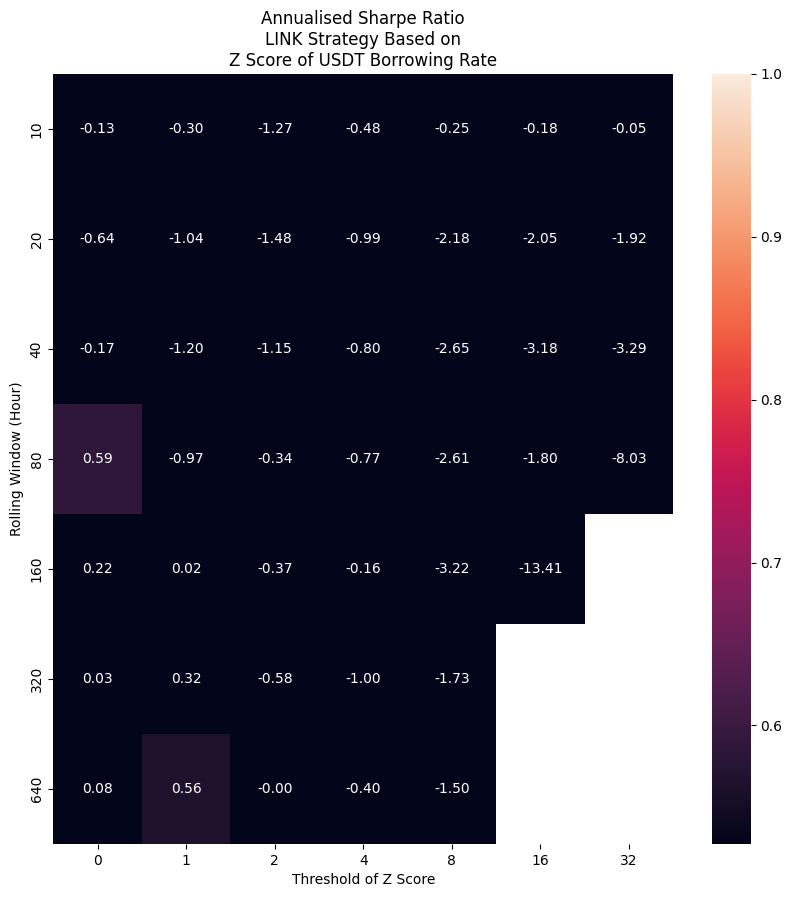

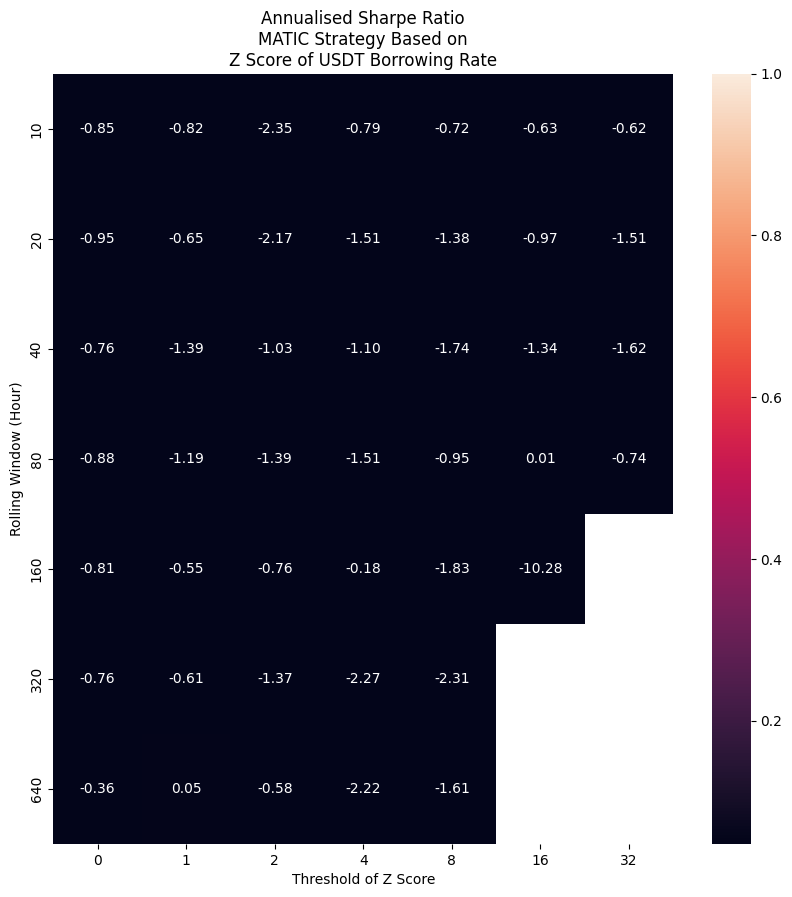

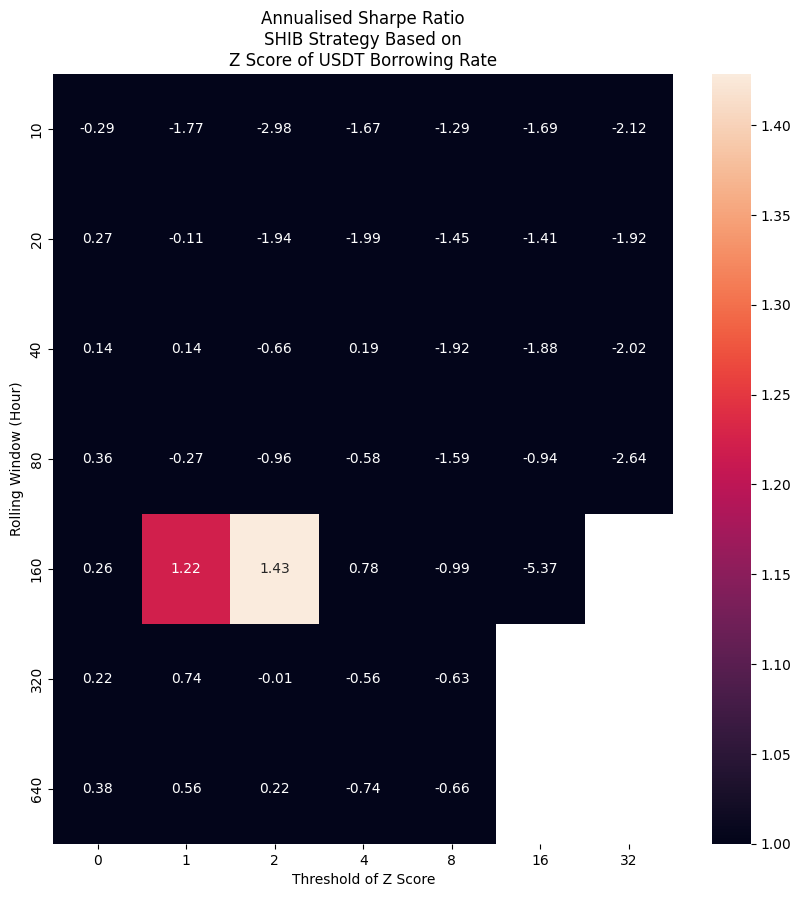

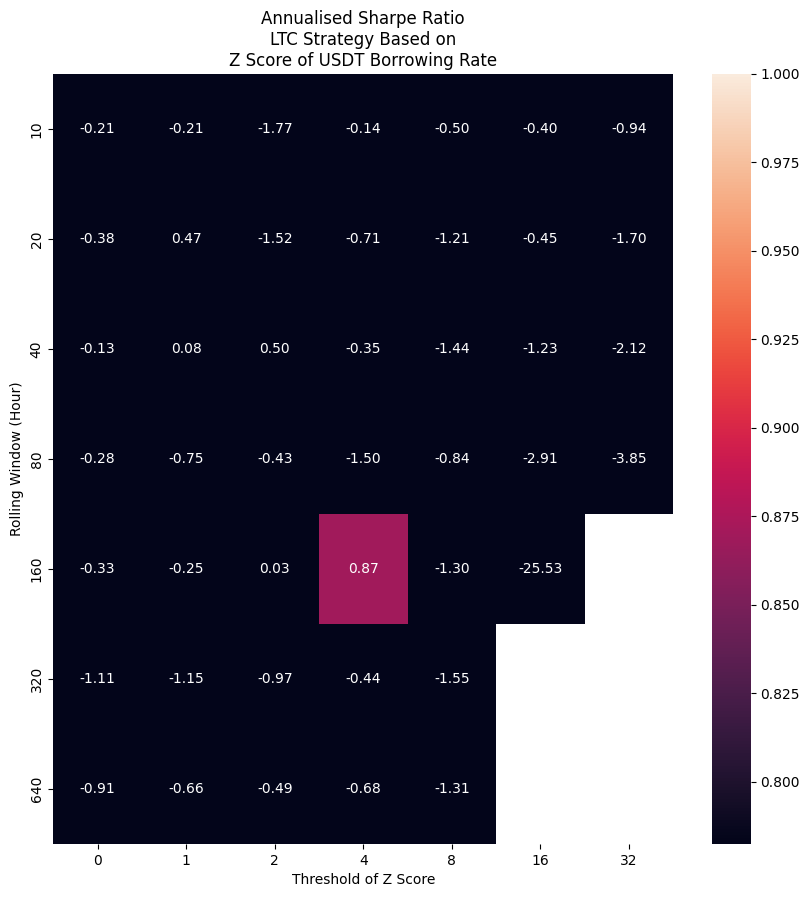

In [11]:
thresholds = [0, 1, 2, 4, 8, 16, 32]
for symbol in tqdm([
    "BTC",
    "ETH",
    "SOL",
    "BNB",
    "XRP",
    "ADA",
    "AVAX",
    "DOGE",
    "DOT",
    "TRX",
    "LINK",
    "MATIC",
    "SHIB",
    "LTC",
]):
    interest_rate_currency = "USDT"
    df_sr = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        df_sr.append(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
    ax.set_title(f"Annualised Sharpe Ratio\n{symbol} Strategy Based on\nZ Score of {interest_rate_currency} Borrowing Rate")
    ax.set_xlabel("Threshold of Z Score")
    ax.set_ylabel("Rolling Window (Hour)")

Running Simulation for SHIB:  43%|███████████████████▎                         | 3/7 [00:02<00:02,  1.47it/s]/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_96720/2082135944.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio=(_df['excess_return'].mean() / _df['excess_return'].std()) if len(trades) > 0 else None,

100%|████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.81s/it]


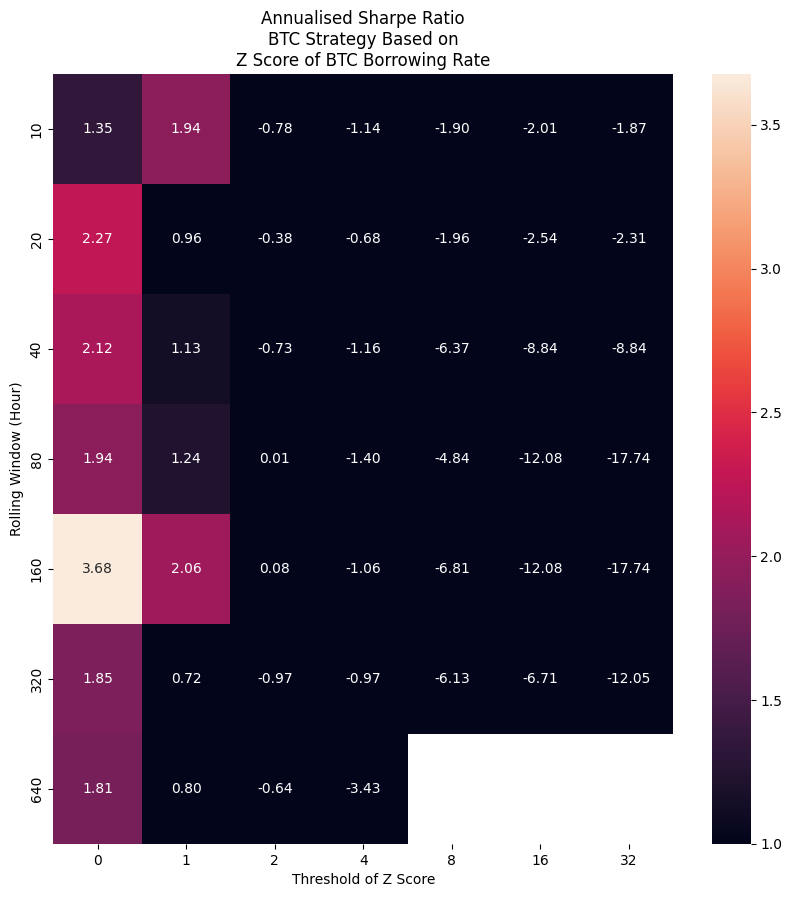

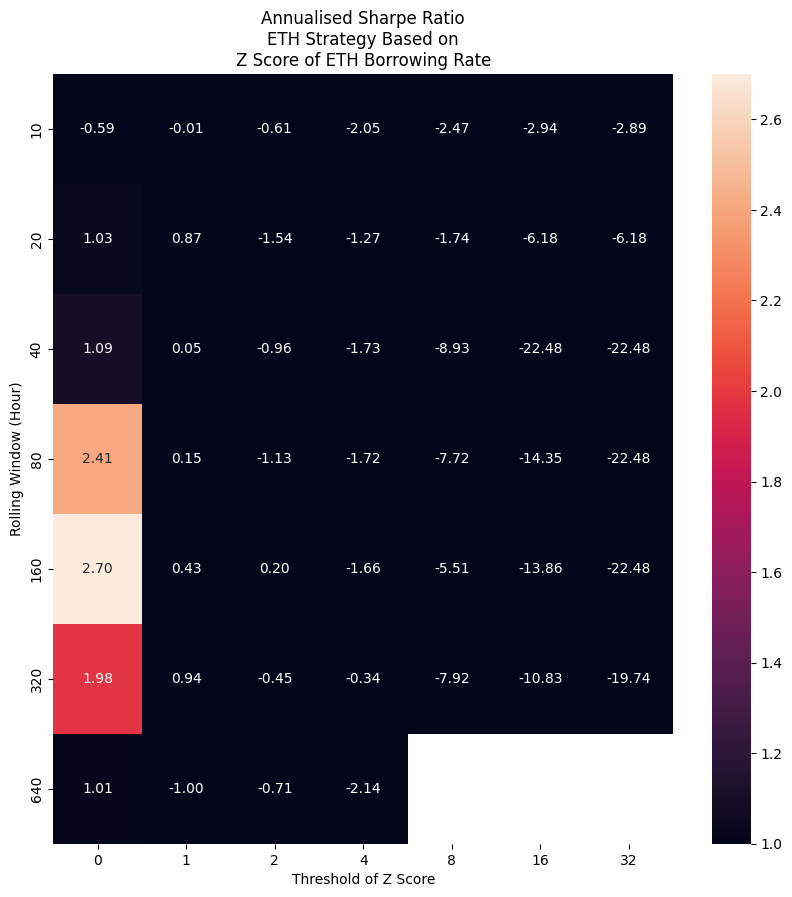

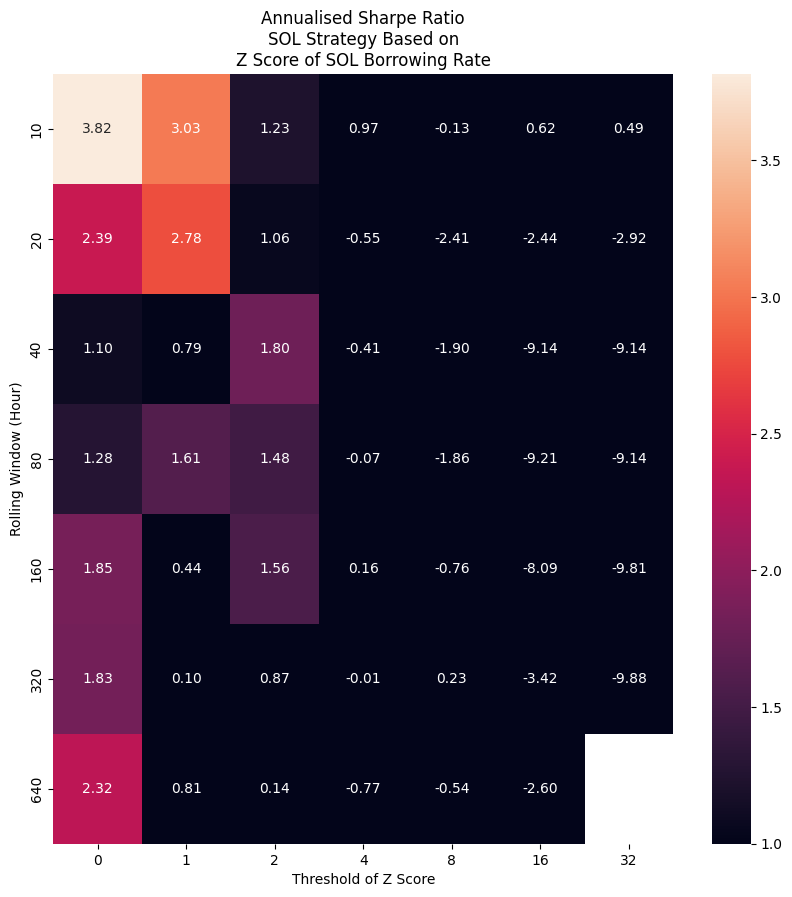

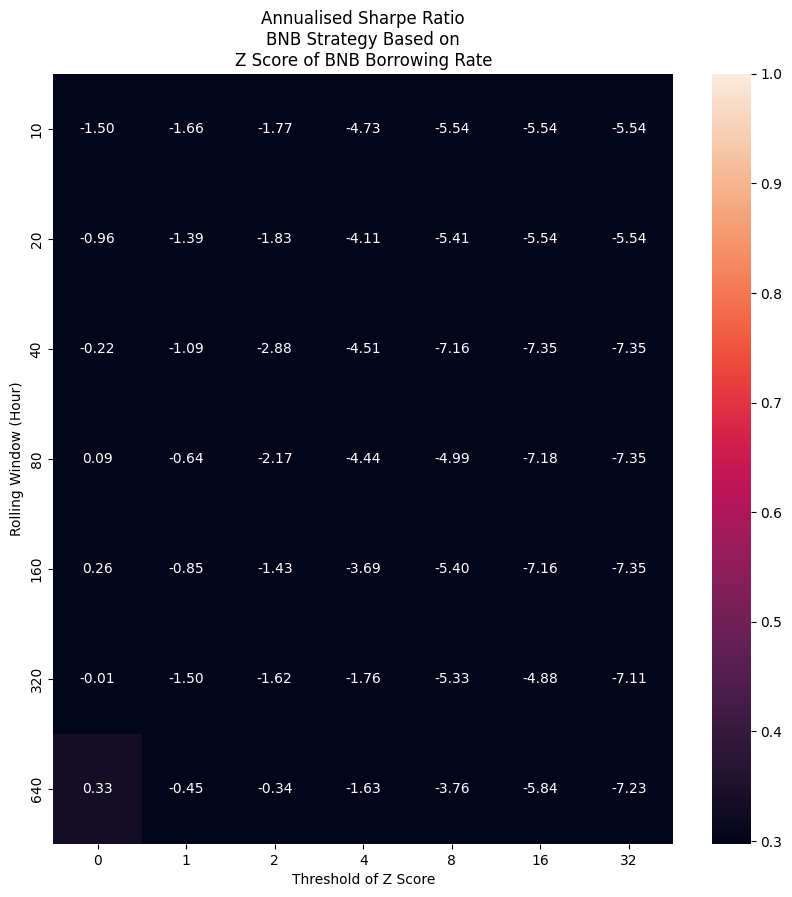

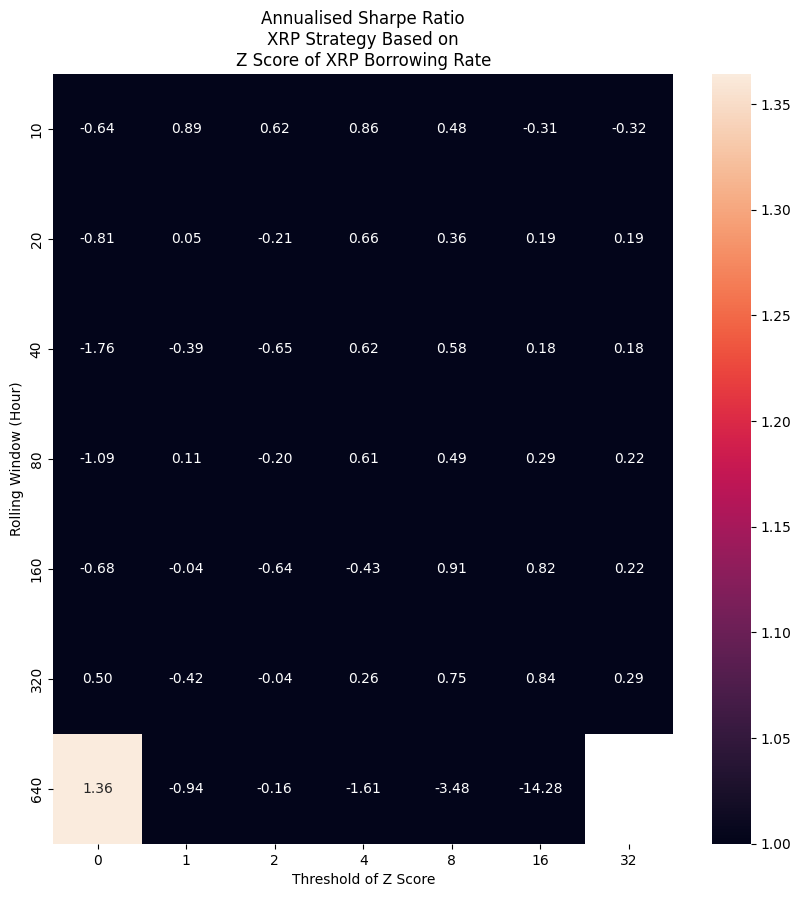

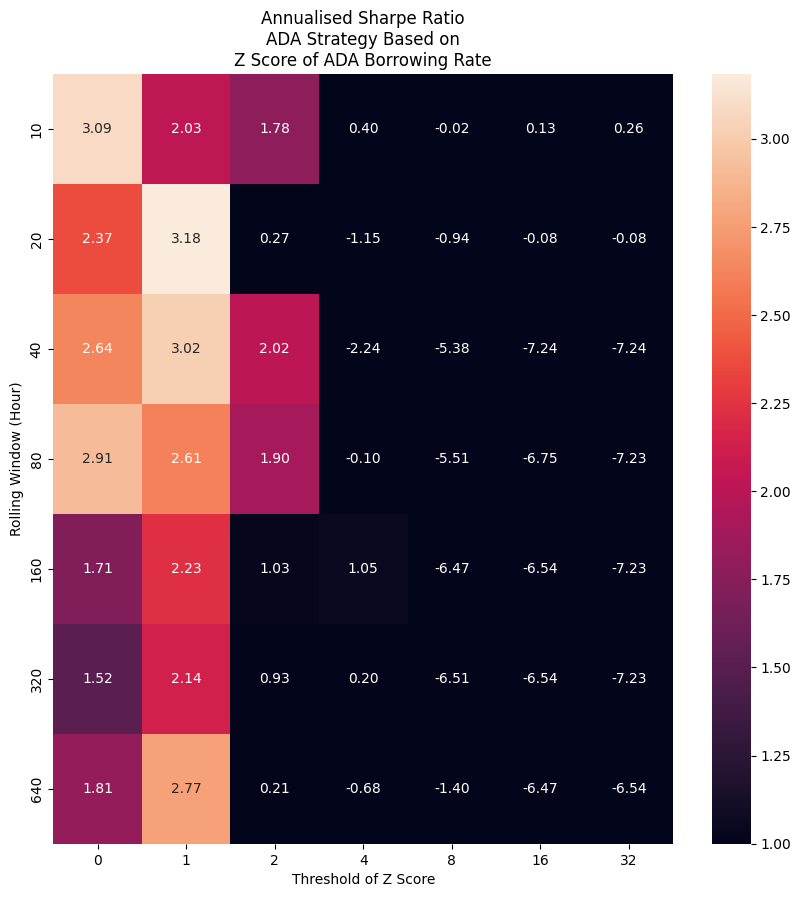

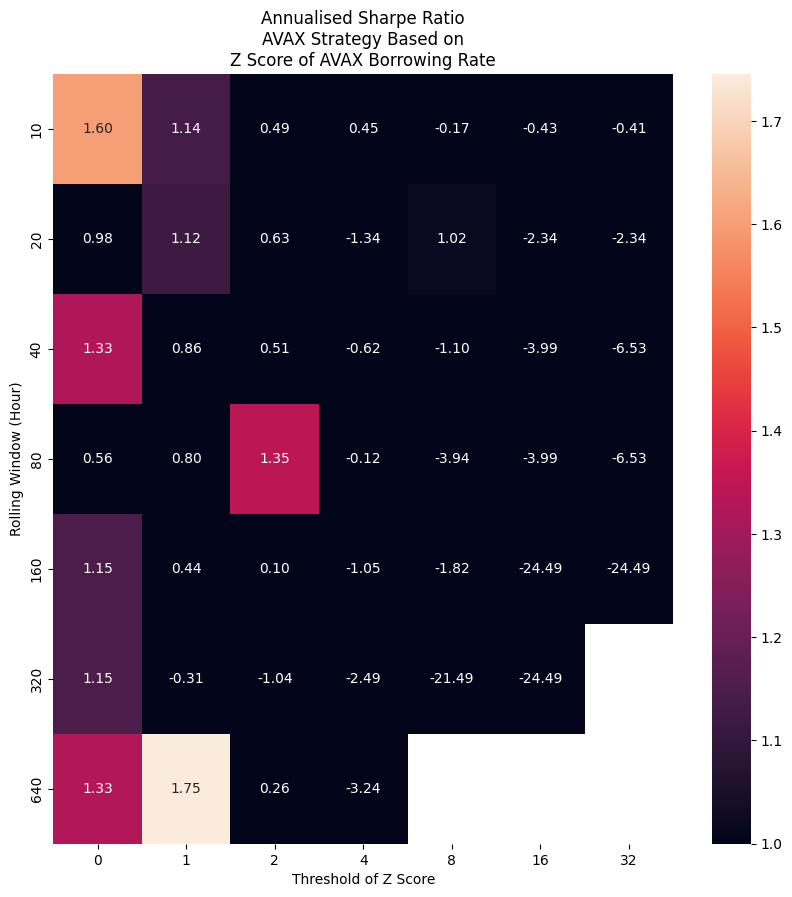

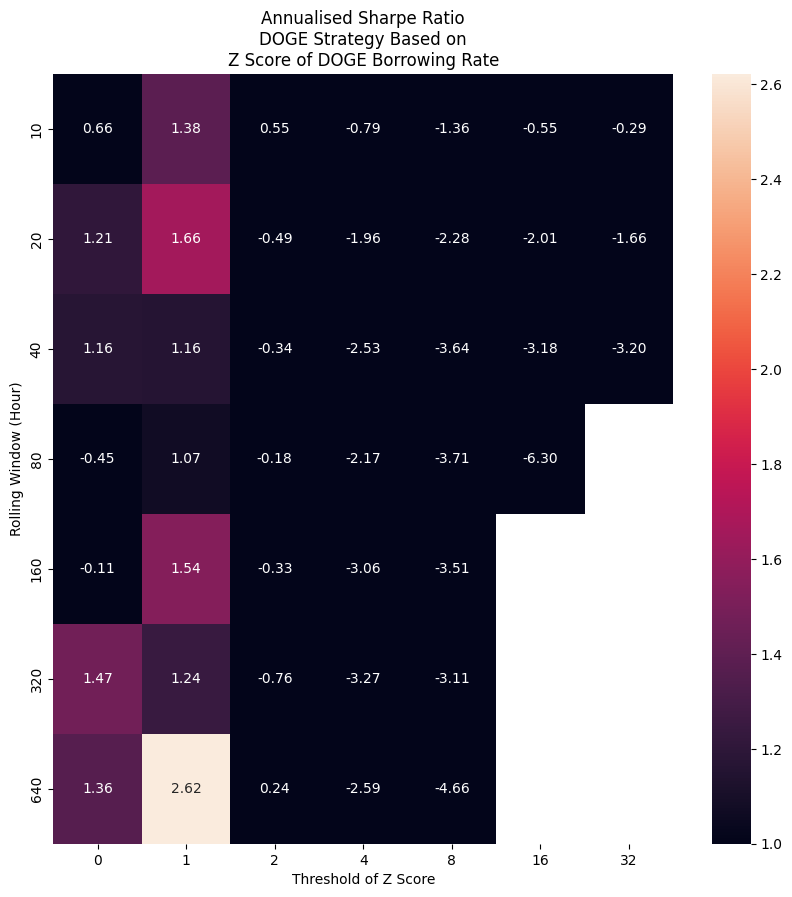

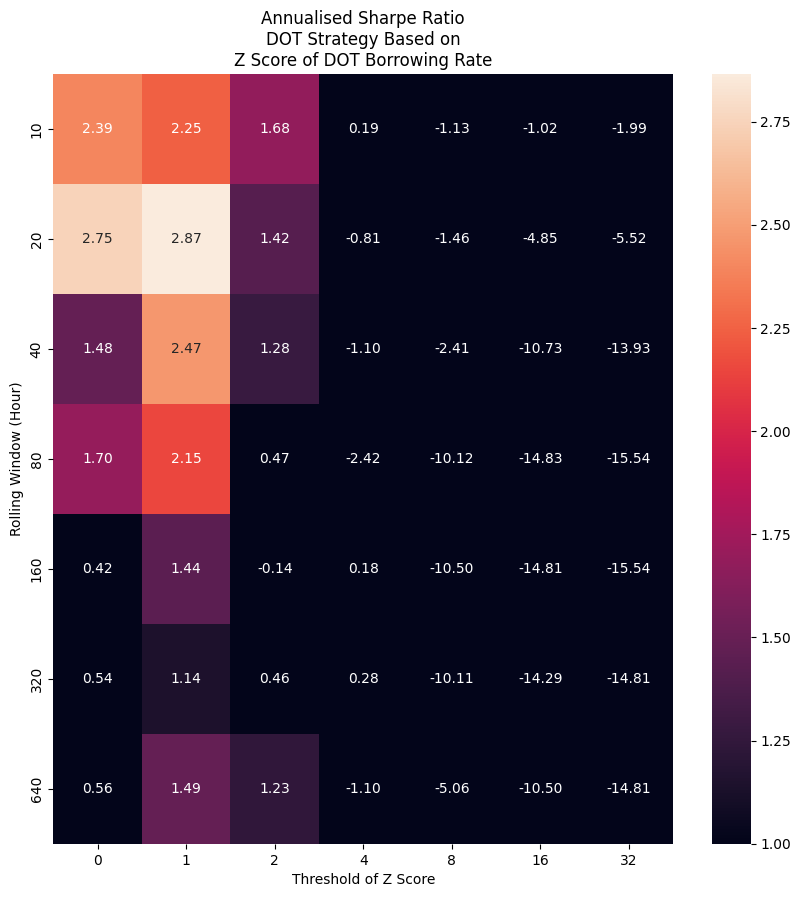

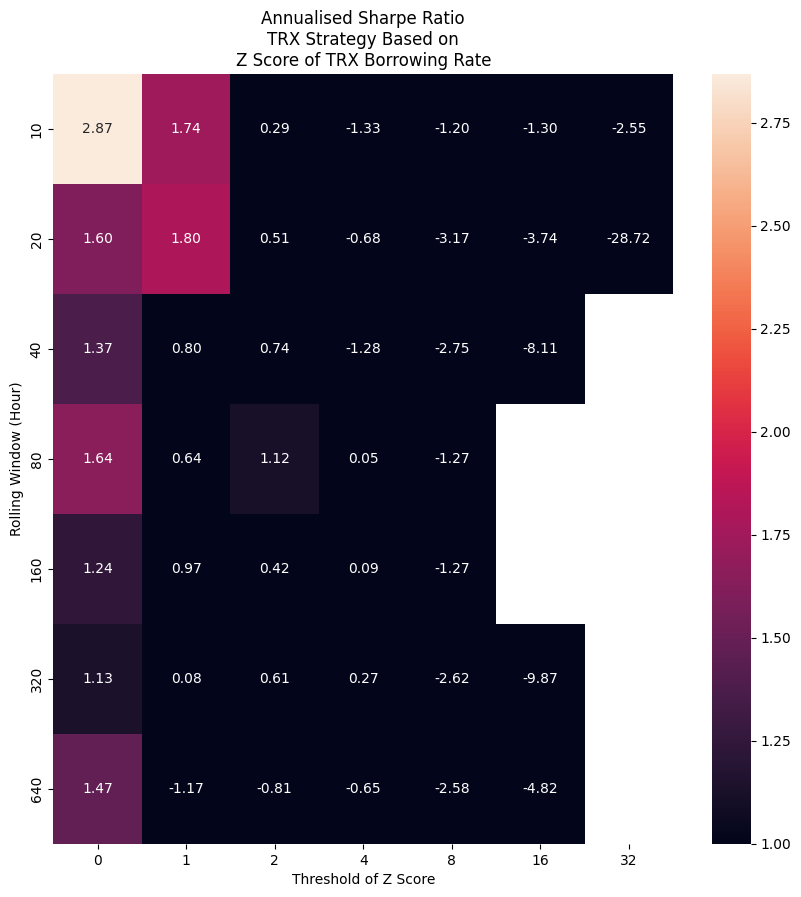

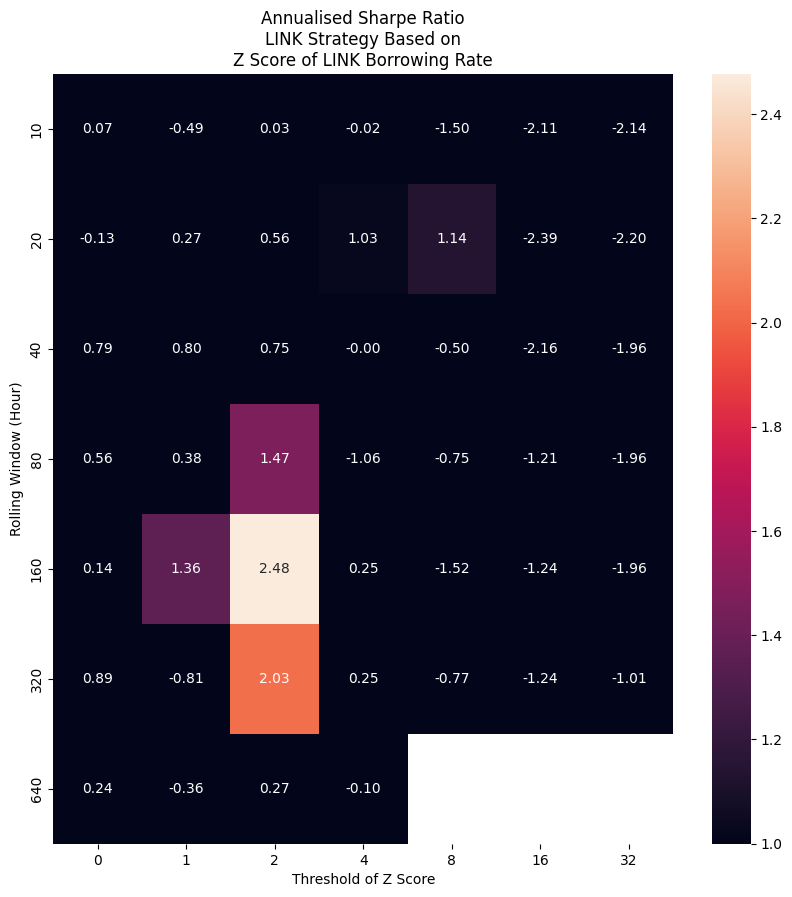

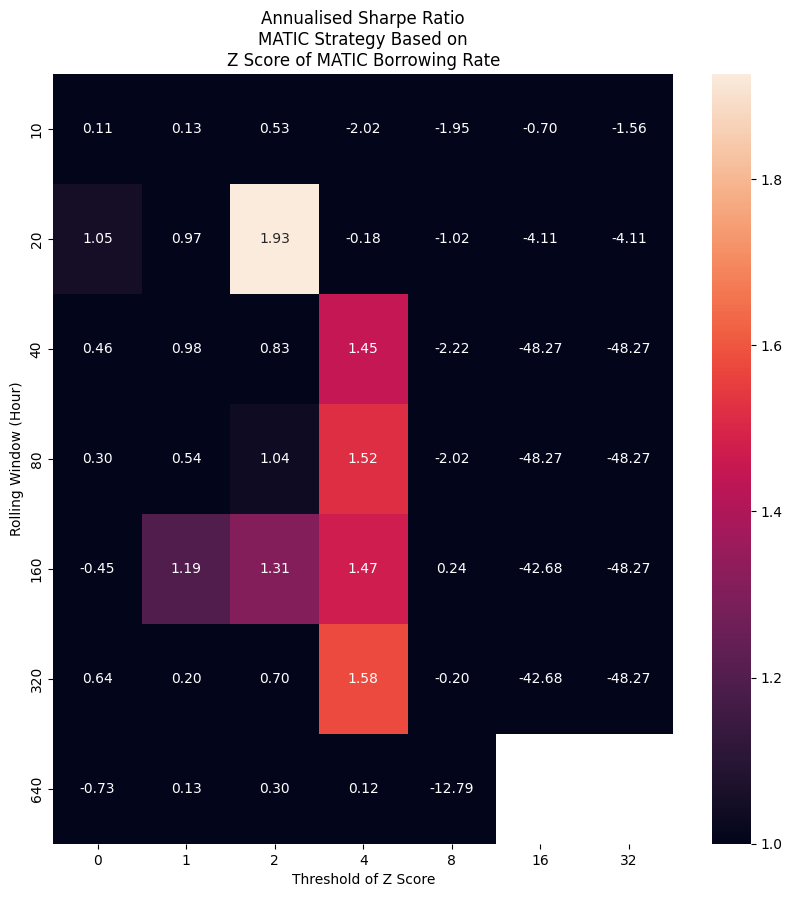

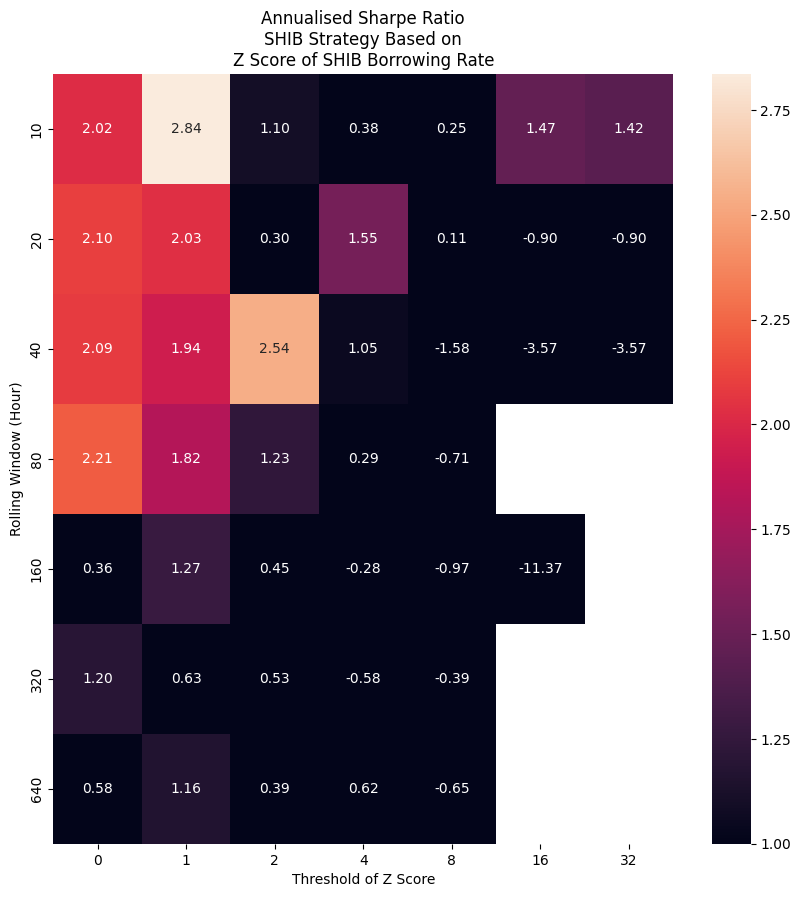

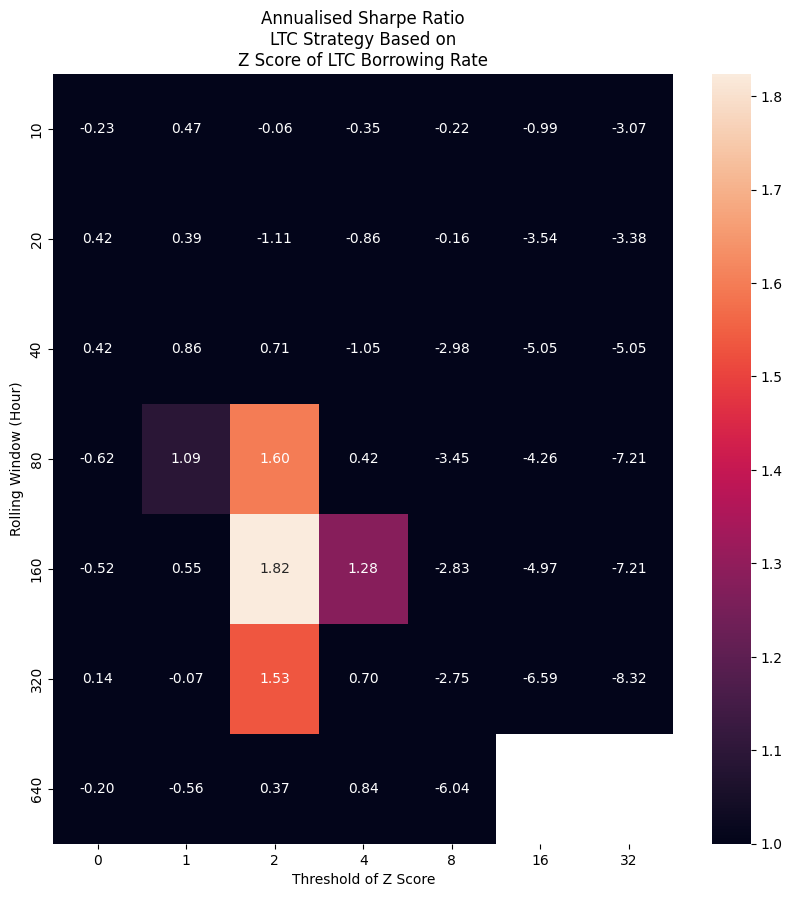

In [12]:
thresholds = [0, 1, 2, 4, 8, 16, 32]
for symbol in tqdm([
    "BTC",
    "ETH",
    "SOL",
    "BNB",
    "XRP",
    "ADA",
    "AVAX",
    "DOGE",
    "DOT",
    "TRX",
    "LINK",
    "MATIC",
    "SHIB",
    "LTC",
]):
    interest_rate_currency = symbol
    df_sr = []
    for window in tqdm(windows, desc=f"Running Simulation for {symbol}"):
        df_sr.append(
            [
                run_strategy(
                    starting_capital=100,
                    interest_rate_currency=interest_rate_currency,
                    symbol=f"{symbol}USDT",
                    rolling_window=window,
                    threshold=threshold,
                    risk_free_rate=risk_free_rate
                ).sharpe_ratio
                for threshold in thresholds
            ]
        )
    df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
    ax.set_title(f"Annualised Sharpe Ratio\n{symbol} Strategy Based on\nZ Score of {interest_rate_currency} Borrowing Rate")
    ax.set_xlabel("Threshold of Z Score")
    ax.set_ylabel("Rolling Window (Hour)")

In [13]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="BTC",
    symbol="BTCUSDT",
    rolling_window=160,
    threshold=0.0,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00+00:00\nEnd Date: 2023-12-19 23:00:00+00:00\nNo. Trade: 282\nPnL: 122.88%\nAnnualised Sharpe Ratio: 3.68\nMax Drawdown: 7.73%\nMax Drawdown Period: 1,604\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'BTC', 'symbol': 'BTCUSDT', 'rolling_window': 160, 'threshold': 0.0, 'risk_free_rate': 5.639269406392694e-06}")

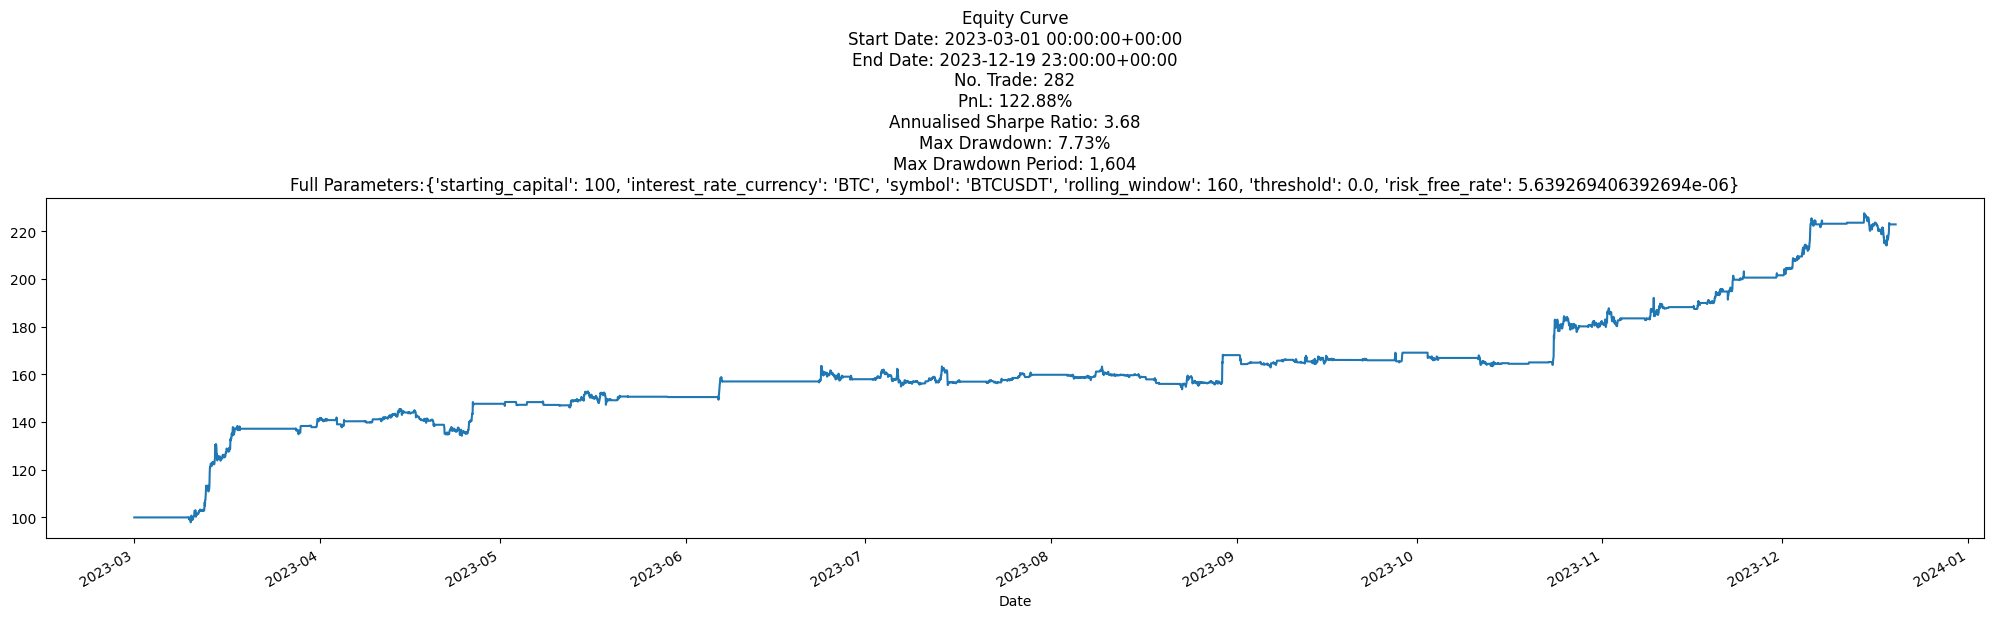

In [14]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")